# [COM4513-6513] Assignment 2: Text Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward network for text classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)
- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)
- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**4 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**4 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)
- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparam combination  (**2 marks**). 
- After training the model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy.
- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).

- **BONUS:** Extend you Feedforward network by adding more hidden layers (e.g. one more). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**+2 extra marks**)



### Data 

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. You are allowed to re-use your code from Assignment 1.

Please make sure to comment your code. You should also mention if you've used Windows to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1 of ~75-80% and ~85% without and with using pre-trained embeddings respectively. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module. If you implement the bonus question you can get up to 2 extra points but your final grade will be capped at 20.

The deadline for this assignment is **23:59 on Mon, 18 May 2020** and it needs to be submitted via Blackboard (MOLE). Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
# Load dateset
data_tr = pd.read_csv("./data_topic/train.csv", header=None, names=['label','text'])
data_te = pd.read_csv("./data_topic/test.csv", header=None, names=['label','text'])
data_dev = pd.read_csv("./data_topic/dev.csv", header=None, names=['label','text'])

In [3]:
# transform test to list, and label to numpy arrays
def transform(df):
    return list(df['text']), df['label'].to_numpy().reshape(-1,1)-1

X_tr_raw, Y_tr = transform(data_tr)
X_te_raw, Y_te = transform(data_te)
X_dev_raw, Y_dev = transform(data_dev)

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [4]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [5]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    
    tokenRE = re.compile(token_pattern)
    
    # first extract all unigrams by tokenising
    x_uni = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
    
    # this is to store the ngrams to be returned
    x = []
    
    if ngram_range[0]==1:
        x = x_uni
    
    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
        
        # ignore unigrams
        if n==1: continue
        
        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1]. 
        # Note that x_uni and x_uni[1:] have different lenghts
        # but zip ignores redundant elements at the end of the second list
        # Alternativel, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)
    
        
    for n in ngrams:
        for t in n:
            x.append(t)
        
    if len(vocab)>0:
        x = [w for w in x if w in vocab]
        
    return x

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [6]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, stop_words=[]):
    
    
    tokenRE = re.compile(token_pattern)
    
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
    
    # interate through each raw text
    for x in X_raw:
        
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, stop_words=stop_words)
        
        #update doc and ngram frequencies 
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set. 
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
    
    # keep the top N most freqent 
    if keep_topN>0:
        vocab = set([w[0] for w in ngram_counts.most_common(keep_topN) if w[0] in vocab])
    
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [7]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,1), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['orioles', 'burks', 'enforcement', 'records', 'contractor', 'kuwait', 'utilities', 'shows', 'banned', 'sporadic', 'bus', 'freezing', 'jonathan', 'musa', 'oil', 'miles', 'begins', 'role', 'rafael', 'philadelphia', 'fasher', 'weightlifting', 'dwindling', 'slip', 'visit', 'witnesses', 'detroit', 'rampage', 'optimism', 'ancient', 'english', 'judge', 'amanda', 'gunmen', 'site', 'powder', 'also', 'mena', 'estimates', 'posed', 'update', 'jazeera', 'ny', 'thin', 'zina', 'tensions', 'blamed', 'appeared', 'benefited', 'sizzling', 'insurgency', 'miracle', 'grove', 'controversy', 'eliminated', 'fear', 'topped', 'qualities', 'shareholder', 'trustworthy', 'abuja', 'packard', 'jumped', 'finance', 'bosnia', 'basketball', 'islamic', 'fed', 'tomko', 'vote', 'cutter', 'malaysian', 'bandanna', 'madrid', 'engine', 'giant', 'accept', 'mohl', 'brett', 'fatal', 'mistake', 'modern', 'overcame', 'hammer', 'problems', 'christmas', 'fixed', 'publicly', 'sorting', 'regulations', 'intc', 'fired', 'activists'

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [8]:
# Calculate the vocab and df of different data sets
vocab_tr, df_tr, ngram_counts_tr = get_vocab(X_tr_raw, ngram_range=(1,1), keep_topN=5000, stop_words=stop_words)
vocab_te, df_te, ngram_counts_te = get_vocab(X_te_raw, ngram_range=(1,1), keep_topN=5000, stop_words=stop_words)
vocab_dev, df_dev, ngram_counts_dev = get_vocab(X_dev_raw, ngram_range=(1,1), keep_topN=5000, stop_words=stop_words)
# create reference
id2vocab = dict(enumerate(vocab_tr))
vocab2id = dict(zip(id2vocab.values(),id2vocab.keys()))

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [9]:
# extract n-grams
X_uni_tr = [extract_ngrams(line,ngram_range=(1,1),stop_words=stop_words) for line in X_tr_raw]
X_uni_te = [extract_ngrams(line,ngram_range=(1,1),stop_words=stop_words) for line in X_te_raw]
X_uni_dev = [extract_ngrams(line,ngram_range=(1,1),stop_words=stop_words) for line in X_dev_raw]

In [10]:
X_uni_tr[0]

['reuters',
 'venezuelans',
 'turned',
 'out',
 'early',
 'large',
 'numbers',
 'sunday',
 'vote',
 'historic',
 'referendum',
 'either',
 'remove',
 'left',
 'wing',
 'president',
 'hugo',
 'chavez',
 'office',
 'give',
 'him',
 'new',
 'mandate',
 'govern',
 'next',
 'two',
 'years']

Then convert them into lists of indices in the vocabulary:

In [11]:
def words2indices(words,index = vocab2id):
    '''Convert a list of words to a list of index
    
    Args:
        words: a list of words
        index: a dictionart, each key is a word, and value is the index
    Return:
        a list of index
    '''
    #words = set(words)&set(vocab2id.keys())
    words = [word for word in words if word in index.keys()]
    return list(map(lambda x:index[x],words))

X_tr = [words2indices(line) for line in X_uni_tr]
X_te = [words2indices(line) for line in X_uni_te]
X_dev = [words2indices(line) for line in X_uni_dev]

In [12]:
X_tr[0]

[3322,
 3476,
 2403,
 340,
 2234,
 885,
 2871,
 1361,
 69,
 2014,
 4832,
 864,
 2743,
 4813,
 880,
 553,
 999,
 3056,
 3373,
 2981,
 4956,
 4704,
 1969,
 1804,
 3406,
 1256,
 187]

Put the labels `Y` for train, dev and test sets into arrays: 

In [13]:
# Already transform to numpy at the beginning of reading CSV
_, Y_tr = transform(data_tr)
_, Y_te = transform(data_te)
_, Y_dev = transform(data_dev)

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W^T) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i^T $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers (for the Bonus). Empty if there are no hidden layers between the average embedding and the output layer 
- `num_clusses`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

See the examples below for expected outputs. Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [14]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    W_emb = np.random.uniform(low = -1*init_val, high = init_val, size = (vocab_size,embedding_dim))
    
    W_h = list()
    pt = embedding_dim
    for layer in hidden_dim:
        W_h.append(np.random.uniform(low = -1*init_val, high = init_val, size = (pt,layer)))
        pt = layer
    W_out = np.random.uniform(low = -1*init_val, high = init_val, size = (pt,num_classes))
    W = [W_emb,*W_h,W_out]

    return W

In [15]:
W = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[], num_classes=2)

print('W_emb:', W[0].shape)
print('W_out:', W[1].shape)

W_emb: (5, 10)
W_out: (10, 2)


In [16]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

In [17]:
print('W_emb:', W[0].shape)
print('W_h1:', W[1].shape)
print('W_out:', W[2].shape)

W_emb: (3, 4)
W_h1: (4, 2)
W_out: (2, 2)


In [18]:
W[0]

array([[-0.40428748,  0.38532683,  0.12724897,  0.22341636],
       [-0.48387079,  0.09443188,  0.05678519, -0.34104036],
       [-0.34692948,  0.19552953, -0.18123357,  0.1919703 ]])

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. It takes as input:

- `z`: array of real numbers 

and returns:

- `sig`: the softmax of `z`

In [19]:
def softmax(z):
    
    '''Calculate softmax results
    
    In order to avoid data overflow, the corresponding data boundary is added.
    Since np.exp() is a `np.float64` operation function, so we need to avoid overflow.
    It is easy to find out the boundary of `np.float64` by calling np.finfo(np.float64).
    Usually, it should be written as `np.minimum(np.exp(z),np.finfo(np.float64).max)`,
    but I prefer to written inside the exp function, since it somehow can be faster.
    For the input of np.exp(), it should not be greater than 709.782 to ensure that the
    output will not overflow.
    
    Returns:
        z: the same size of z.
    '''
    
    z = np.minimum(z,709.782)
    smax = np.exp(z) / np.sum(np.exp(z),axis=z.ndim-1,keepdims=True)
    
    return smax

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:

In [20]:
def categorical_loss(y, y_preds):
    
    '''1. Calculate the Euclidean distance between label and probability
       2. Calculate the average distance
       
    Here I use `esp` to represent the smallest data unit of the data type. 
    The main function of `esp` is to ensure the rationality of arithmetic 
    operations. For example, in the division operation, add `esp` to the 
    denominator to ensure that the denominator is not 0, and it does not 
    affect the data result. This is the habit I developed when I wrote Matlab
    in my undergraduate period. `esp` is more common in Matlab.
    Input:
        y->int/list: 2;[2],[[2],[2]]
        y_preds->np.ndarry: [1,0,0];[[1,0,0]];[[1,0,0],[1,0,0]]
    Args:
        eps: the minimum value in the current data type. Used to ensure
            that the input of the log function is greater than 0.
        preds_proba: Probability of each data, the same
            size of input data.(X.shape[0])

    Returns:
        l: Used to save losses and calculate the average at the end
    '''
    
    Y = np.array(y)
    assert type(y_preds) == np.ndarray
    try:
        n,d = y_preds.shape
    except:
        n=1
        d = y_preds.shape[0]
    #eps = np.finfo(np.float64).eps
    Y = np.eye(d,d)[Y].reshape(n,d)
    #l1 = -np.sum(Y*np.log(y_preds+eps),1) 
    y_preds = np.maximum(y_preds,np.finfo(np.float64).eps)
    assert np.all(y_preds>0)
    l1 = -np.sum(Y*np.log(y_preds),1) 
    l=np.mean(l1)
    assert l>=0
    return l

In [21]:
# example for 5 classes

y = 2 #true label
y_preds = softmax(np.array([[-2.1,1.,0.9,-1.3,1.5]]))[0]

print('y_preds: ',y_preds)
print('loss:', categorical_loss(y, y_preds))

y_preds:  [0.01217919 0.27035308 0.24462558 0.02710529 0.44573687]
loss: 1.40802648485675


Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network (during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

\begin{equation}
  \text{relu_derivative}(z_i)=\begin{cases}
    0, & \text{if $z_i<=0$}.\\
    1, & \text{otherwise}.
  \end{cases}
\end{equation}

Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [22]:
def relu(z):
    
    '''ReLu activation function
    Input: 
        z->np.ndarry: array([-1,1,0,-2,2])
    
    Return:
        a->np.ndarry: array([0,1,0,0,2])
    '''
    
    a = np.fmax(z, 0)
    return a
    
def relu_derivative(z):
    
    '''Derivative of ReLu activation function
    Input: 
        z->np.ndarry: array([-0.5,0.5,0,-2,2])
    
    Return:
        dz->np.ndarry: array([0,1,0,0,1])
    '''
    
    dz = np.fmax(z,0)
    np.sign(dz,out=dz)
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [23]:
def dropout_mask(size, dropout_rate):
    
    '''Dropout matrix
    Input: 
        size->np.shape
        dropout_rate->int: 0.0~1,0
    
    Return:
        dropout_vec->np.ndarry: if p =0.2, array([1,0,1,1,1])
    '''
    
    dropout_vec = np.full(size,1.0)
    index = np.arange(size)
    np.random.shuffle(index)
    dropout_vec[index[:int(size*dropout_rate)]]=0
    
    return dropout_vec

In [24]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 0. 1. 1. 1. 1. 1. 0. 1.]
[1. 1. 1. 1. 0. 1. 1. 0. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [25]:
def initial_h0(x,W):
    
    '''mapping words' index into an Embedding weight matrix
    Input: 
        x->list: a list of words' index
        W->np.ndarry: embedding weight matrix
    Returns:
        h->np.ndarry: mapping index and compute the first hidden layer
    
    '''
    
    if type(x[0])!=list:
        h = np.zeros(W.shape[1])
        for index in range(len(x)):
            np.add(W[x[index]]/len(x),h,out=h) # with mean value
    else:
        h = np.zeros((len(x),W.shape[1]))
        for i in range(len(x)):
            for index in range(len(x[i])):
                h[i,:] += W[x[i][index]]/len(x[i])
    return h

def forward_linear(A_prev, W, dropout_rate):
    
    '''Linear forward:
        1. h = a*W
        2. a = relu(h)    
    '''
    
    h = np.dot(A_prev, W)
    a = relu(h)
    dropout = dropout_mask(a.shape[a.ndim-1],dropout_rate)
    return h,a,dropout

def forward_pass(x, W, dropout_rate=0.2):
    ''' Feed forward network
    '''
    out_vals = {}
    
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    
    # one-hot input layer to embedding weight matrix (with mean)
    h = initial_h0(x,W[0])
    A = relu(h) # ReLu activation
    dropout = dropout_mask(A.shape[A.ndim-1],dropout_rate) # Dropout
    h_vecs.append(h);a_vecs.append(A);dropout_vecs.append(dropout)
    A = np.multiply(A,dropout)
    
    # Hidden layers
    L = len(W)
    for l in range(1,L-1):
        A_prev = A 
        # Activation, dropout
        h,A,dropout = forward_linear(A_prev,W[l],dropout_rate)
        h_vecs.append(h);a_vecs.append(A);dropout_vecs.append(dropout)
        A = np.multiply(A,dropout)
        
    # Output layer
    A_prev = A 
    h,A,dropout = forward_linear(A_prev,W[-1],dropout_rate)
    np.multiply(A,dropout,out=A)
    y = softmax(A) # softmax function mapping vector to probability
    
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vec'] = dropout_vecs
    out_vals['y'] = y
    
    return out_vals

In [26]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[5], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

print()
print(forward_pass([2,1], W, dropout_rate=0.5))

Shape W0 (3, 4)
Shape W1 (4, 5)
Shape W2 (5, 2)

{'h': [array([-0.04668262, -0.12518335,  0.17532285, -0.32932054]), array([0., 0., 0., 0., 0.])], 'a': [array([0.        , 0.        , 0.17532285, 0.        ]), array([0., 0., 0., 0., 0.])], 'dropout_vec': [array([1., 0., 0., 1.]), array([0., 0., 1., 1., 1.])], 'y': array([0.5, 0.5])}


The `backward_pass` function computes the gradients and update the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [27]:
def backward_linear(dh,A_prev,W):
    ''' linear back-propagation
    '''
    A_prev = A_prev.reshape(1,-1)
    dW = np.dot(A_prev.T, dh)
    dA_prev = np.dot(dh, W.T)
    return dW,dA_prev

def backward_dropout(dA, A_prev, W, dropout):
    ''' dropout back-propagation
    '''
    dW,dA_prev = backward_linear(dA, A_prev,W)
    np.multiply(dA_prev,dropout,out=dA_prev) 
    return dW,dA_prev

def backward_activation(dA, h):
    ''' ReLu back-propagation
    '''
    dh = relu_derivative(h)*dA
    return dh

def backward_pass(x, Y, W, out_vals, lr=0.001, freeze_emb=False):
    ''' Back-propagation
    '''
    # output layer
    y_preds = out_vals['y']
    dh = y_preds-Y # gradient dL/dh
    dh = backward_activation(dh,y_preds)
    
    # hidden layers
    L = len(W)
    for l in range(1,L):
        A_prev = out_vals['a'][-1*l]
        # Gradient, Dropout
        dW,dA_prev = backward_dropout(dh, A_prev,W[-1*l],out_vals['dropout_vec'][-1*l])
        # Activation
        dh = backward_activation(dA_prev,out_vals['h'][-1*l])

        np.multiply(lr,dW,out = dW)
        np.subtract(W[-1*l],dW,out = W[-1*l])
    
    # input layers
    if not freeze_emb:
        X = np.array(x).reshape(-1,1)/len(x)
        dW = np.dot(X,dh)

        np.multiply(lr,dW,out=dW)
        for index in range(len(x)):
            W[0][x[index]] -= dW[index]
      
    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [28]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []
    
    # Stage 1: transform label into vector
    num_classes = W[-1].shape[1]
    Y_tr_pre = np.eye(num_classes,num_classes)[Y_tr].reshape(len(Y_tr),-1)
    
    # Stage 2: Init stochastic value
    idx_list = np.array(range(len(X_tr)))
    
    t_forward = 0
    t_backward = 0
    for epoch in range(epochs):
        np.random.shuffle(idx_list) # disorder dataset
        for i in idx_list:
            # get single data
            X_tr_i, Y_tr_i = X_tr[i],Y_tr_pre[i]
            # Forward pass
            out_vals = forward_pass(X_tr_i, W, dropout_rate=dropout)
            # Backward pass
            W = backward_pass(X_tr_i, Y_tr_i.reshape(1,-1), W, out_vals, lr=lr, freeze_emb=False)
        
        # training loss
        y_preds = forward_pass(X_tr, W, dropout_rate=0)['y']
        loss_tr = categorical_loss(Y_tr, y_preds)
        # evaluation loss
        y_preds = forward_pass(X_dev, W, dropout_rate=0)['y']
        loss_dev = categorical_loss(Y_dev, y_preds)

        # Add history
        training_loss_history.append(loss_tr)
        validation_loss_history.append(loss_dev)
        
        if print_progress == True: 
            print("Epoch: %d| Training loss: %f| Validation loss: %f"%(epoch+1,loss_tr,loss_dev))
            
        if epoch >1 and (validation_loss_history[-2]-validation_loss_history[-1]) <= tolerance:
            break
    
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [29]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.00001, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.01,
                            epochs=50)


Shape W0 (5000, 300)
Shape W1 (300, 3)
Epoch: 1| Training loss: 1.054929| Validation loss: 1.058958
Epoch: 2| Training loss: 1.008315| Validation loss: 1.027526
Epoch: 3| Training loss: 0.965575| Validation loss: 0.998296
Epoch: 4| Training loss: 0.925864| Validation loss: 0.970511
Epoch: 5| Training loss: 0.888951| Validation loss: 0.943728
Epoch: 6| Training loss: 0.854548| Validation loss: 0.918253
Epoch: 7| Training loss: 0.822345| Validation loss: 0.894002
Epoch: 8| Training loss: 0.792326| Validation loss: 0.871088
Epoch: 9| Training loss: 0.764303| Validation loss: 0.849147
Epoch: 10| Training loss: 0.737963| Validation loss: 0.828149
Epoch: 11| Training loss: 0.713255| Validation loss: 0.807997
Epoch: 12| Training loss: 0.690119| Validation loss: 0.788818
Epoch: 13| Training loss: 0.668344| Validation loss: 0.770632
Epoch: 14| Training loss: 0.647915| Validation loss: 0.753052
Epoch: 15| Training loss: 0.628591| Validation loss: 0.736090
Epoch: 16| Training loss: 0.610489| Vali

Plot the learning process:

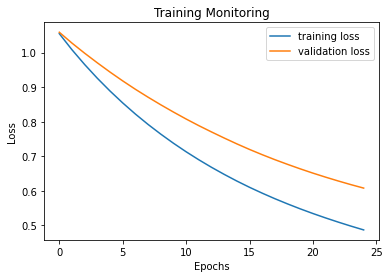

In [30]:
%matplotlib inline
fig = plt.figure()
plt.plot(range(len(loss_tr)),loss_tr,label='training loss')
plt.plot(range(len(dev_loss)),dev_loss,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring')

plt.legend()
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [31]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8177777777777778
Precision: 0.8174437765948438
Recall: 0.8177777777777778
F1-Score: 0.8164168081508762


### Discuss how did you choose model hyperparameters ? 

**Choose Model Hyperparameters:**

To choose hyperparameters, like dropout and embedding size, they can be found by drawing a line chart. Basically, use a grid search to find the optimal hyperparameters. This method is simple but time-consuming. Ideally, cross-validation should be used to screen the optimal hyperparameters, but because the training and validation sets have been divided, cross-validation is not very convenient.(Code of grid search is given below)

**note:** The following hyperparameter optimization has limitations. Only a fixed training set and verification set are used. Ideally, it should be divided into multiple groups and cross-validation should be used. See, [Leave-One-Out Cross-Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation).

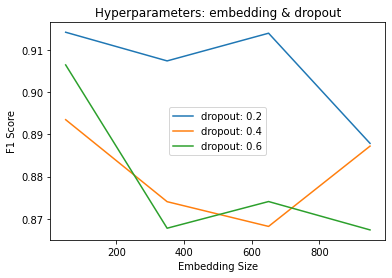

In [32]:
# Initial hyperparameters
fig = plt.figure()
embeddings = [50,350,650,950]
dropouts = [0.2,0.4,0.6]
embeddings_num = len(embeddings)
dropouts_num = len(dropouts)

# Run trainings on different sets of hyperparameters
for i in range(dropouts_num):
    # Dropout Tune
    dropout = dropouts[i]
    tmp = list()
    for j in range(embeddings_num):
        # Embedding Tune
        embedding = embeddings[j]
        W = network_weights(vocab_size=len(vocab),embedding_dim=embedding,hidden_dim=[], num_classes=3)
        W, _, _ = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.0001, 
                            dropout=dropout,
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=50,
                            print_progress=False)
        preds_dev = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_dev,Y_dev)]
        score = f1_score(Y_dev,preds_dev,average='macro')
        tmp.append(score)
    plt.plot(embeddings,tmp,label='dropout: {}'.format(dropout))
    
plt.xlabel('Embedding Size')
plt.ylabel('F1 Score')
plt.title('Hyperparameters: embedding & dropout')

plt.legend()
plt.show()

**Chart description:**

As shown in the figure above, the X axis represents the embedding size, and the Y axis refers to the accuracy rate. And different colored polylines indicate different dropout.

**Embedding:** When the embedding size increases, the performance on the verification set gradually decreases. This may indicate that too large an embedding size is not necessarily good.

**Dropout:** At the same time, it is worth noting that as the dropout increases, the performance also gradually declines.

**After Tuning, and set to best hyperparameters:**
* Dropout: 0.2
* Embedding Size: 650

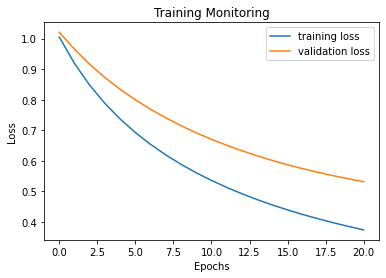

Accuracy: 0.8111111111111111
Precision: 0.8121017577078377
Recall: 0.811111111111111
F1-Score: 0.8100213844625325


In [37]:
W = network_weights(vocab_size=len(vocab),embedding_dim=650,hidden_dim=[], num_classes=3)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.00001, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.01,
                            epochs=50,
                            print_progress=False)

fig = plt.figure()
plt.plot(range(len(loss_tr)),loss_tr,label='training loss')
plt.plot(range(len(dev_loss)),dev_loss,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring')

plt.legend()
plt.show()

preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary.

In [38]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [39]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",vocab2id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [40]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3)
W[0] = w_glove
W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.0001, 
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=50)

Epoch: 1| Training loss: 0.742232| Validation loss: 0.848288
Epoch: 2| Training loss: 0.553284| Validation loss: 0.705833
Epoch: 3| Training loss: 0.449172| Validation loss: 0.622520
Epoch: 4| Training loss: 0.381603| Validation loss: 0.563187
Epoch: 5| Training loss: 0.333123| Validation loss: 0.521103
Epoch: 6| Training loss: 0.295180| Validation loss: 0.488474
Epoch: 7| Training loss: 0.265242| Validation loss: 0.462202
Epoch: 8| Training loss: 0.240493| Validation loss: 0.442782
Epoch: 9| Training loss: 0.219987| Validation loss: 0.424984
Epoch: 10| Training loss: 0.202043| Validation loss: 0.411479
Epoch: 11| Training loss: 0.185942| Validation loss: 0.399799
Epoch: 12| Training loss: 0.172182| Validation loss: 0.390815
Epoch: 13| Training loss: 0.159965| Validation loss: 0.382011
Epoch: 14| Training loss: 0.148822| Validation loss: 0.375543
Epoch: 15| Training loss: 0.139095| Validation loss: 0.369182
Epoch: 16| Training loss: 0.130418| Validation loss: 0.362481
Epoch: 17| Traini

In [41]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8411111111111111
Precision: 0.8498343733441617
Recall: 0.8411111111111111
F1-Score: 0.841701026388176


**Comparison of results:**

By comparing the pre-trained and untrained embedding results, we can find that the pre-trained embedding model performs better, but this is also limited. Using a pre-trained embedding model can slightly improve the performance of the model.

### Discuss how did you choose model hyperparameters ? 

**Choose Model Hyperparameters:**

To choose hyperparameters, like dropout and embedding size, they can be found by drawing a line chart. Basically, use a grid search to find the optimal hyperparameters. This method is simple but time-consuming. Ideally, cross-validation should be used to screen the optimal hyperparameters, but because the training and validation sets have been divided, cross-validation is not very convenient.(Code of grid search is given below)

**note:** The following hyperparameter optimization has limitations. Only a fixed training set and verification set are used. Ideally, it should be divided into multiple groups and cross-validation should be used. See, [Leave-One-Out Cross-Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation).

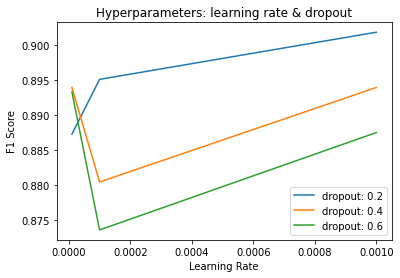

In [42]:
# Initial hyperparameters
fig = plt.figure()
lrs = [0.001,0.0001,0.00001]
dropouts = [0.2,0.4,0.6]
lr_num = len(lrs)
dropouts_num = len(dropouts)

# Run trainings on different sets of hyperparameters
for i in range(dropouts_num):
    # Dropout Tune
    dropout = dropouts[i]
    tmp = list()
    for j in range(lr_num):
        # Embedding Tune
        lr = lrs[j]
        W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3)
        W[0] = w_glove
        W, _, _ = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=lr, 
                            dropout=dropout,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=50,
                            print_progress=False)
        preds_dev = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_dev,Y_dev)]
        score = f1_score(Y_dev,preds_dev,average='macro')
        tmp.append(score)
    plt.plot(lrs,tmp,label='dropout: {}'.format(dropout))
    
plt.xlabel('Learning Rate')
plt.ylabel('F1 Score')
plt.title('Hyperparameters: learning rate & dropout')

plt.legend()
plt.show()

**Chart description:**

As shown in the figure above, the X axis represents the embedding size, and the Y axis refers to the accuracy rate. And different colored polylines indicate different dropout.

**Dropout:** At the same time, it is worth noting that as the dropout increases, the performance also gradually declines.

**Learning rate:** When the learning rate is large, it will not be able to converge to the lowest point, making the model performance worse.

**After Tuning, and set to best hyperparameters:**
* Dropout: 0.2
* Learning rate: 0.001

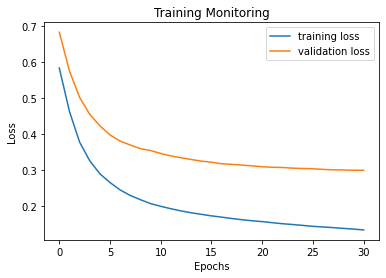

Accuracy: 0.8411111111111111
Precision: 0.8457026908834138
Recall: 0.8411111111111111
F1-Score: 0.8412613813013546


In [44]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3)
W[0] = w_glove
W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0.0001,
                            epochs=50,
                            print_progress=False)

fig = plt.figure()
plt.plot(range(len(loss_tr)),loss_tr,label='training loss')
plt.plot(range(len(dev_loss)),dev_loss,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring')

plt.legend()
plt.show()

preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

# Extend to support deeper architectures (Bonus)

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. 

In [45]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[100,30], num_classes=3)
W[0] = w_glove
W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.000001, 
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=50)

Epoch: 1| Training loss: 10.850649| Validation loss: 8.606941
Epoch: 2| Training loss: 9.671159| Validation loss: 7.509455
Epoch: 3| Training loss: 8.553329| Validation loss: 6.514850
Epoch: 4| Training loss: 7.578110| Validation loss: 5.673981
Epoch: 5| Training loss: 6.751562| Validation loss: 4.979463
Epoch: 6| Training loss: 6.032103| Validation loss: 4.397106
Epoch: 7| Training loss: 5.408632| Validation loss: 3.915014
Epoch: 8| Training loss: 4.890166| Validation loss: 3.535966
Epoch: 9| Training loss: 4.412994| Validation loss: 3.198515
Epoch: 10| Training loss: 3.969365| Validation loss: 2.886754
Epoch: 11| Training loss: 3.547853| Validation loss: 2.598655
Epoch: 12| Training loss: 3.097134| Validation loss: 2.308672
Epoch: 13| Training loss: 2.668030| Validation loss: 2.049226
Epoch: 14| Training loss: 2.233956| Validation loss: 1.798375
Epoch: 15| Training loss: 1.835578| Validation loss: 1.579538
Epoch: 16| Training loss: 1.506585| Validation loss: 1.409317
Epoch: 17| Train

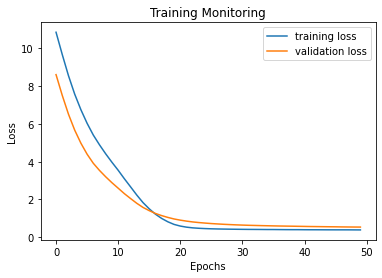

In [46]:
fig = plt.figure()
plt.plot(range(len(loss_tr)),loss_tr,label='training loss')
plt.plot(range(len(dev_loss)),dev_loss,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring')

plt.legend()
plt.show()

In [47]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8044444444444444
Precision: 0.8036439607706726
Recall: 0.8044444444444445
F1-Score: 0.8030810897033458


**Use tuning to choose model hyperparameters:**

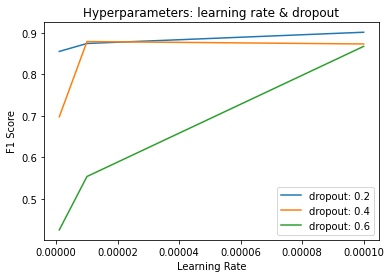

In [48]:
# Initial hyperparameters
fig = plt.figure()
lrs = [0.0001,0.00001,0.000001]
dropouts = [0.2,0.4,0.6]
lr_num = len(lrs)
dropouts_num = len(dropouts)

# Run trainings on different sets of hyperparameters
for i in range(dropouts_num):
    # Dropout Tune
    dropout = dropouts[i]
    tmp = list()
    for j in range(lr_num):
        # Embedding Tune
        lr = lrs[j]
        W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[100,30], num_classes=3)
        W[0] = w_glove
        W, _, _ = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=lr, 
                            dropout=dropout,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=50,
                            print_progress=False)
        preds_dev = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_dev,Y_dev)]
        score = f1_score(Y_dev,preds_dev,average='macro')
        tmp.append(score)
    plt.plot(lrs,tmp,label='dropout: {}'.format(dropout))
    
plt.xlabel('Learning Rate')
plt.ylabel('F1 Score')
plt.title('Hyperparameters: learning rate & dropout')

plt.legend()
plt.show()

**After Tuning, and set to best hyperparameters:**
* Dropout: 0.2
* Learning rate: 0.0001

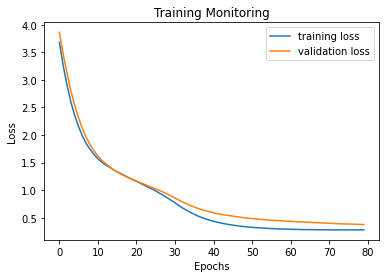

Accuracy: 0.8122222222222222
Precision: 0.8248228309127356
Recall: 0.8122222222222222
F1-Score: 0.813196611152632


In [55]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[100,30], num_classes=3)
W[0] = w_glove
W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.000001, 
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=-0.01,
                            epochs=80,
                            print_progress=False)

fig = plt.figure()
plt.plot(range(len(loss_tr)),loss_tr,label='training loss')
plt.plot(range(len(dev_loss)),dev_loss,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring')

plt.legend()
plt.show()

preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.812  |  0.811 |  0.810 |  0.811 |
| Average Embedding (Pre-trained)  |  0.845 | 0.841  | 0.841  |   0.841|
| Average Embedding (Pre-trained) + X hidden layers (BONUS)   | 0.824  | 0.812  |  0.813 |  0.812 |


**Performance:** 

Pre-trained Embedding > Pre-trained Embedding + hidden layers > Embedding

* It may be because there are many parameters in the multilayer neural network, and it is more difficult to converge to the global lowest point. So the final F1 score is not particularly high. 

* Another reason is that because SGD is used instead of GD, the gradient in SGD does not necessarily point to the global lowest point, but to the lower point under the current data point.

But overall, the three models have achieved good performance levels, all exceeding 80%.